# Cancer Detection

In [1]:
import numpy as np
import pandas as pd
import scipy

#https://www.kaggle.com/code/gomezp/complete-beginner-s-guide-eda-keras-lb-0-93
from glob import glob 
import tensorflow as tf
import keras,cv2,os

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation, Input, concatenate
from keras.layers import Conv2D, MaxPool2D
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import gc

In [12]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("TensorFlow version:", tf.__version__)

Num GPUs Available:  1
TensorFlow version: 2.10.1


Goal is to train a model to identify images containing cancer. I am provided with training images and labels to discover patterns and apply it to unseen validation data.
To simplify associating images with labels I will create a dataframe to associate the image filenames with label data

In [6]:
#https://www.kaggle.com/code/gomezp/complete-beginner-s-guide-eda-keras-lb-0-93
base_path = os.path.dirname(os.path.abspath('notebook.ipynb'))
data_path = os.path.join(base_path, "data")
train_path = os.path.join(data_path, 'train')
test_path = os.path.join(data_path, 'test')

# Load the filenames
df = pd.DataFrame({'path': glob(os.path.join(train_path, '*.tif'))})

# Extract the file names and keep only the file names in 'id'
df['id'] = df.path.map(lambda x: os.path.splitext(os.path.basename(x))[0])

# Read the provided labels
labels = pd.read_csv(os.path.join(data_path, "train_labels.csv"))

# Merge labels and filepaths
df = df.merge(labels, on="id")

I want to learn more about the dataset I am working with. Let's see some useful stats and info

In [30]:
print(f'{len(os.listdir(train_path))} pictures in train.')
print(f'{len(os.listdir(test_path))} pictures in test.')

220025 pictures in train.
57458 pictures in test.


# Load Data

In [4]:
def load_data(N,df):
    """ This functions loads N images using the data df
    """
    # allocate a numpy array for the images (N, 96x96px, 3 channels, values 0 - 255)
    X = np.zeros([N,96,96,3],dtype=np.uint8) 
    #convert the labels to a numpy array too
    y = y = np.squeeze(df[['label']].values)[0:N]
    #read images one by one, tdqm notebook displays a progress bar
    for i, row in tqdm(df.iterrows(), total=N):
        if i == N:
            break
        X[i] = cv2.imread(row['path'])
          
    return X,y

In [ ]:

N=10000
X,y = load_data(N=N,df=df) 

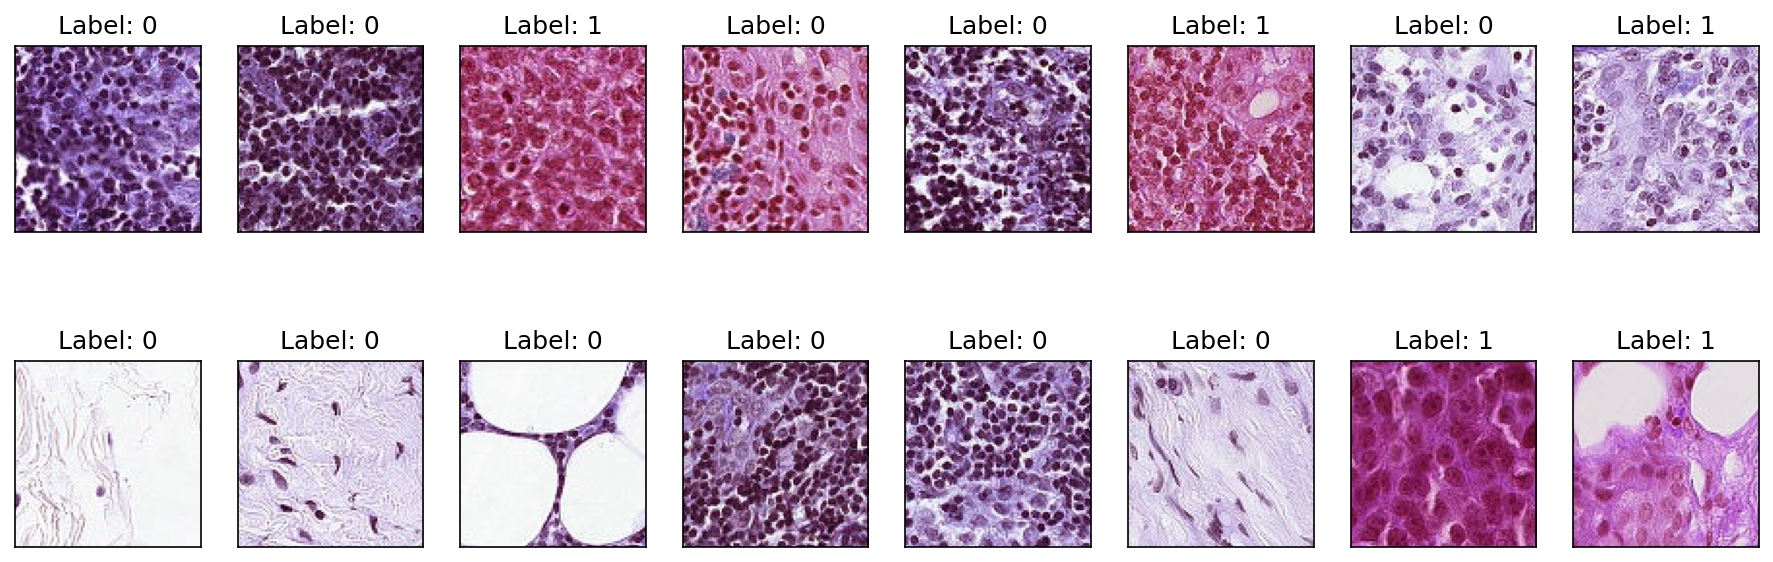

In [18]:
def display_images(X, y, num_images=10):
    fig = plt.figure(figsize=(15, 5), dpi=150)
    np.random.seed(100)  # Seed for reproducibility
    selected_indices = np.random.choice(len(X), num_images, replace=False)
    for plotNr, idx in enumerate(selected_indices):
        ax = fig.add_subplot(2, num_images // 2, plotNr + 1, xticks=[], yticks=[])  # Add subplots
        plt.imshow(X[idx])  # Plot image
        ax.set_title(f'Label: {y[idx]}')  # Show the label corresponding to the image
    plt.show()

display_images(X, y, num_images=16)

I'm interested if I can visually see any patterns between label 1 and label 0

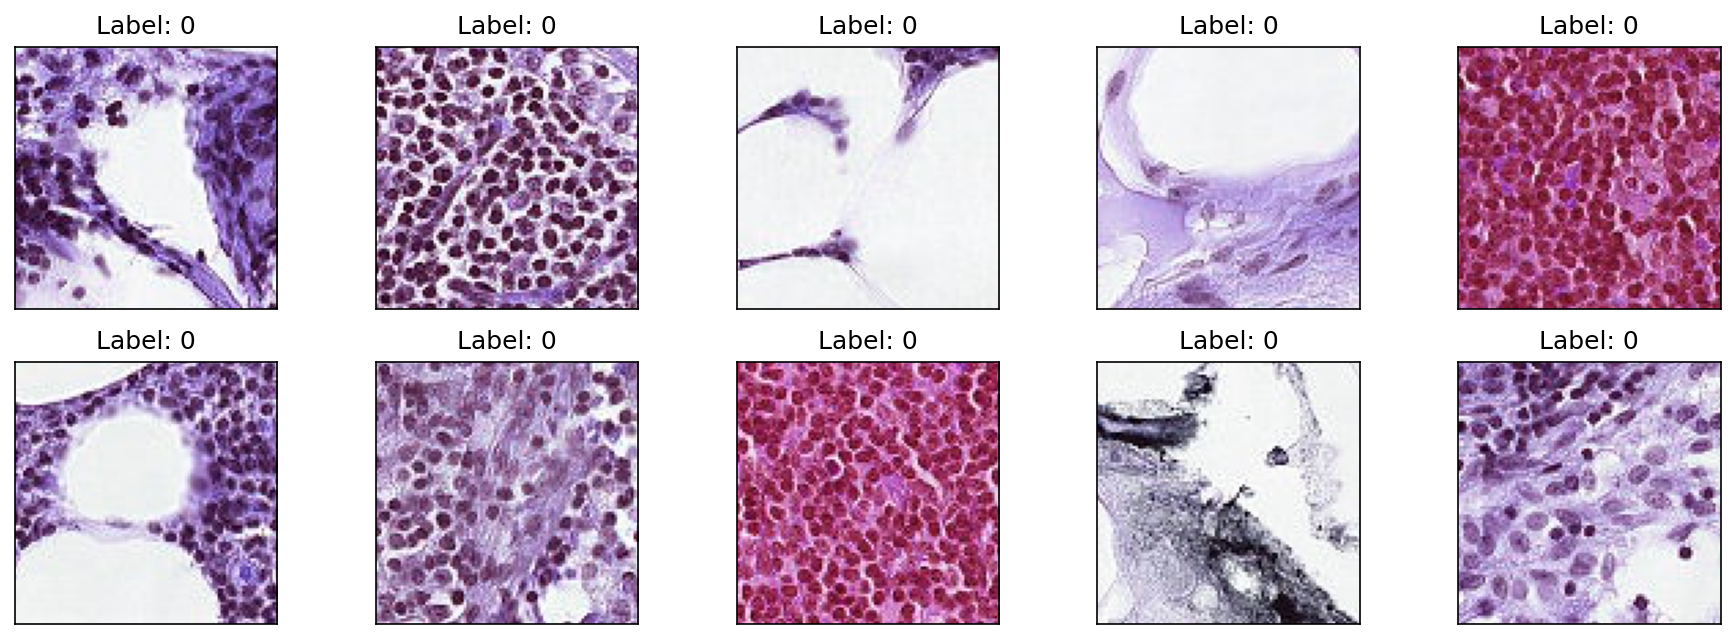

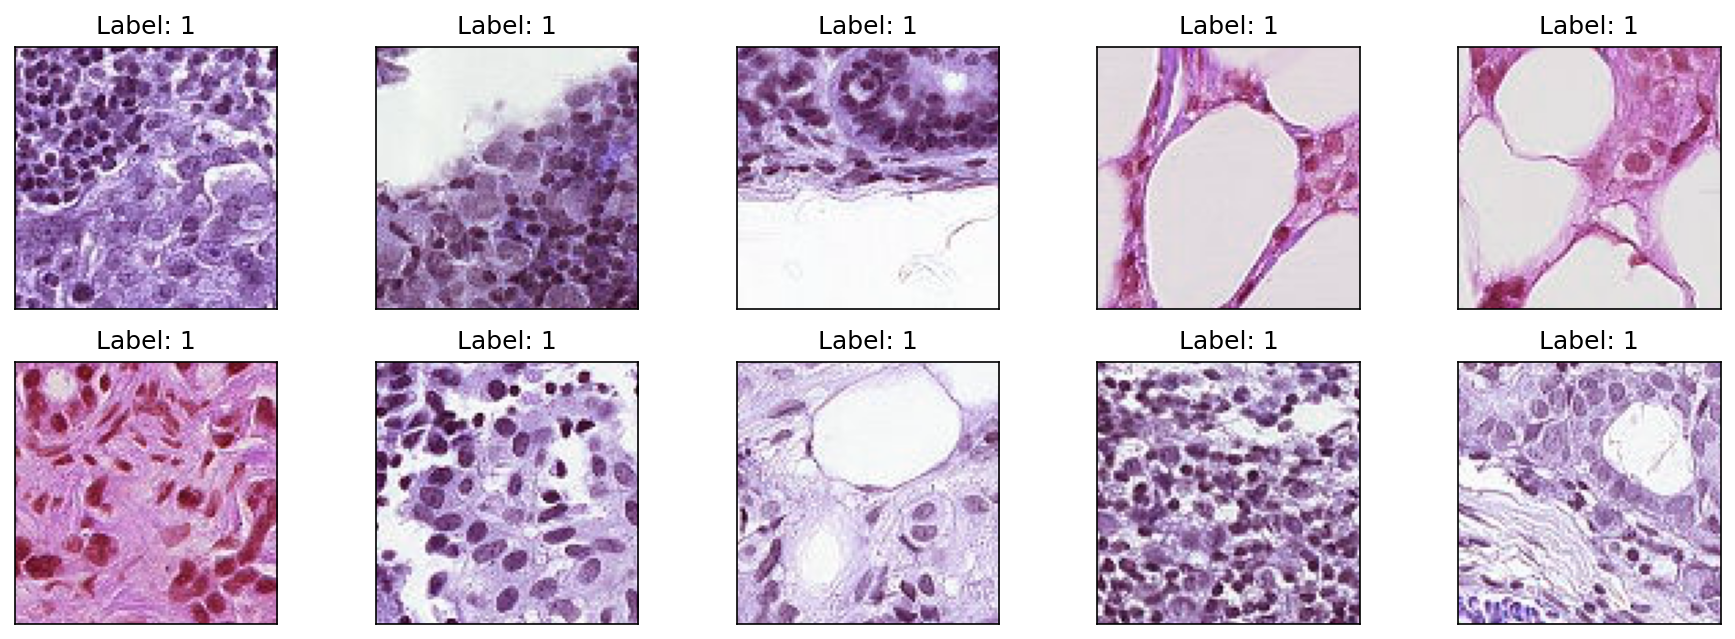

In [35]:
def display_images_by_label(X, y, label, num_images=10):
    fig = plt.figure(figsize=(15, 5), dpi=150)
    np.random.seed(100)  # Seed for reproducibility
    label_indices = np.where(y == label)[0]
    selected_indices = np.random.choice(label_indices, num_images, replace=False)
    for plotNr, idx in enumerate(selected_indices):
        ax = fig.add_subplot(2, num_images // 2, plotNr + 1, xticks=[], yticks=[])  # Add subplots
        plt.imshow(X[idx])  # Plot image
        ax.set_title(f'Label: {y[idx]}')  # Show the label corresponding to the image
    plt.show()

# Display 10 images with label 0
display_images_by_label(X, y, label=0)

# Display 10 images with label 1
display_images_by_label(X, y, label=1)

Without research into medicine, I can't identify what part of the image makes it cancerous. However, one conclusion I did take away from this is images labeled 0 have some low-quality, seemingly garbage images. I may want to try and clean up the data, but I want to see the difference between cleanup and leaving data as is.

How does the distribution of 0/1 labels look?

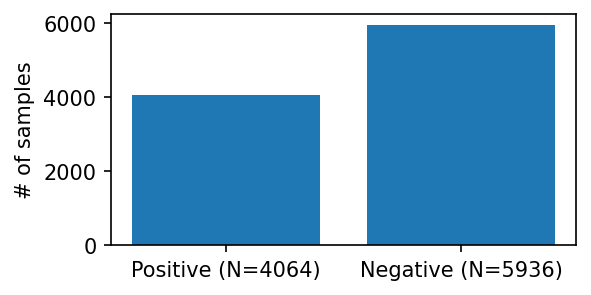

In [42]:
fig = plt.figure(figsize=(4, 2),dpi=150)
plt.bar([1,0], [(y==0).sum(), (y==1).sum()])
plt.xticks([1,0],["Negative (N={})".format((y==0).sum()),"Positive (N={})".format((y==1).sum())])
plt.ylabel("# of samples")
plt.show()

In [43]:
positive_samples = X[y == 1]
negative_samples = X[y == 0]

Maybe cancer cells have a certain color, so there will be more of a certain rgb value in different labeled images?

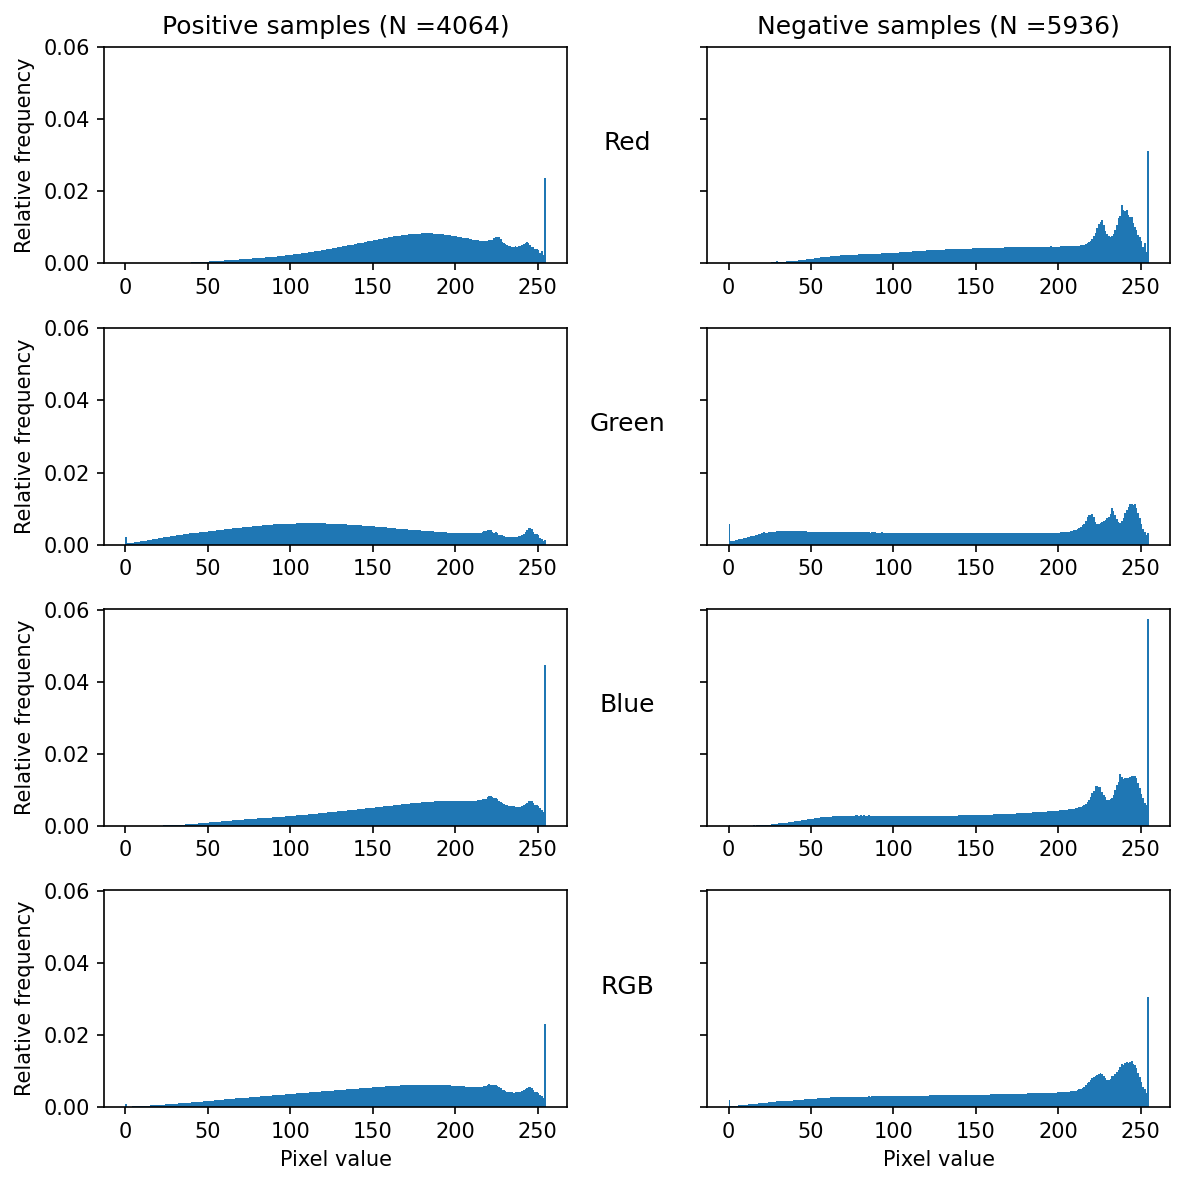

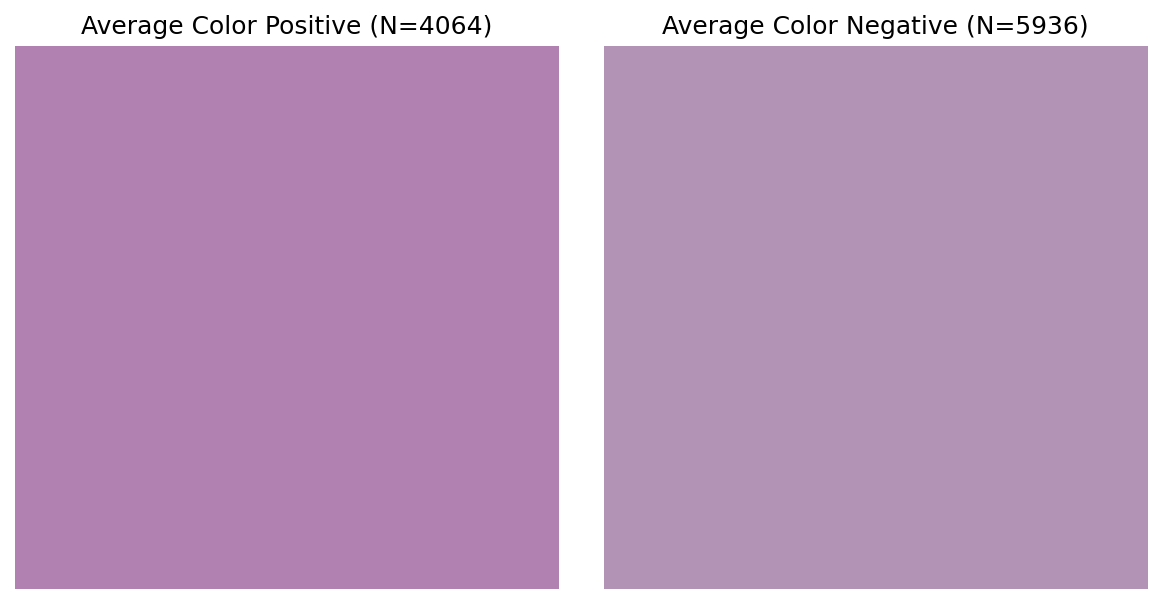

In [45]:
nr_of_bins = 256 #each possible pixel value will get a bin in the following histograms
fig,axs = plt.subplots(4,2,sharey=True,figsize=(8,8),dpi=150)

#RGB channels
axs[0,0].hist(positive_samples[:,:,:,0].flatten(),bins=nr_of_bins,density=True)
axs[0,1].hist(negative_samples[:,:,:,0].flatten(),bins=nr_of_bins,density=True)
axs[1,0].hist(positive_samples[:,:,:,1].flatten(),bins=nr_of_bins,density=True)
axs[1,1].hist(negative_samples[:,:,:,1].flatten(),bins=nr_of_bins,density=True)
axs[2,0].hist(positive_samples[:,:,:,2].flatten(),bins=nr_of_bins,density=True)
axs[2,1].hist(negative_samples[:,:,:,2].flatten(),bins=nr_of_bins,density=True)

#All channels
axs[3,0].hist(positive_samples.flatten(),bins=nr_of_bins,density=True)
axs[3,1].hist(negative_samples.flatten(),bins=nr_of_bins,density=True)

#Set image labels
axs[0,0].set_title("Positive samples (N =" + str(positive_samples.shape[0]) + ")");
axs[0,1].set_title("Negative samples (N =" + str(negative_samples.shape[0]) + ")");
axs[0,1].set_ylabel("Red",rotation='horizontal',labelpad=35,fontsize=12)
axs[1,1].set_ylabel("Green",rotation='horizontal',labelpad=35,fontsize=12)
axs[2,1].set_ylabel("Blue",rotation='horizontal',labelpad=35,fontsize=12)
axs[3,1].set_ylabel("RGB",rotation='horizontal',labelpad=35,fontsize=12)
for i in range(4):
    axs[i,0].set_ylabel("Relative frequency")
axs[3,0].set_xlabel("Pixel value")
axs[3,1].set_xlabel("Pixel value")
fig.tight_layout()

#calculate the average color for positive and negative samples
mean_color_positive = positive_samples.mean(axis=(0, 1, 2))
mean_color_negative = negative_samples.mean(axis=(0, 1, 2))

fig, axs = plt.subplots(1, 2, figsize=(8, 4), dpi=150)

positive_color_img = np.ones((100, 100, 3), dtype=np.uint8) * mean_color_positive.astype(np.uint8)
axs[0].imshow(positive_color_img)
axs[0].set_title(f'Average Color Positive (N={positive_samples.shape[0]})')
axs[0].axis('off')

negative_color_img = np.ones((100, 100, 3), dtype=np.uint8) * mean_color_negative.astype(np.uint8)
axs[1].imshow(negative_color_img)
axs[1].set_title(f'Average Color Negative (N={negative_samples.shape[0]})')
axs[1].axis('off')

plt.tight_layout()
plt.show()

Interesting. It is clear there are some differences between positive and negative samples. My biggest takeaway from these graphs is that it seems cancerous images have much darker color and a different overall shade. The most prominent feature I see is that cancerous cells miss a certain green peak, in fact the same bandwith appears to have a bowl as if the color range was cut out. This could be a useful feature to find cancerous cells.\
It's also important to note the large spike on the right side of the graphs, representing bright white light from the microscope going through clear sections of the cells.

Going a step further, I want to see if different images have distinct brightness properties, since it looks like there are many more peaks to the right in the negative samples 

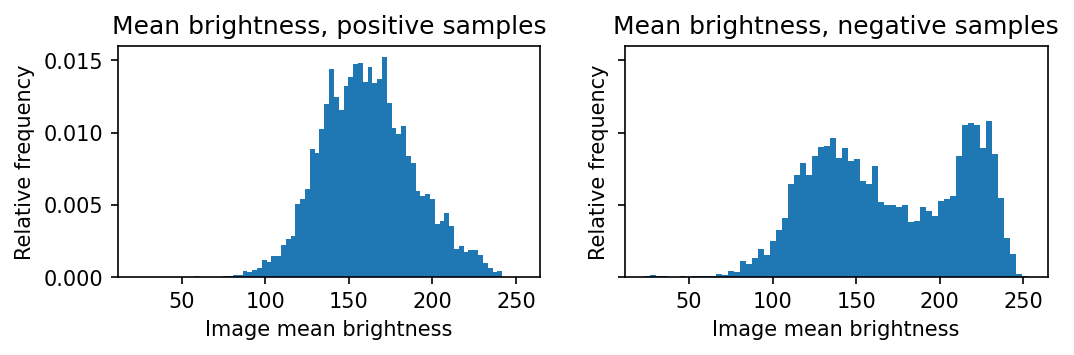

In [48]:
nr_of_bins = 64 #we use a bit fewer bins to get a smoother image
fig,axs = plt.subplots(1,2,sharey=True, sharex = True, figsize=(8,2),dpi=150)
axs[0].hist(np.mean(positive_samples,axis=(1,2,3)),bins=nr_of_bins,density=True);
axs[1].hist(np.mean(negative_samples,axis=(1,2,3)),bins=nr_of_bins,density=True);
axs[0].set_title("Mean brightness, positive samples");
axs[1].set_title("Mean brightness, negative samples");
axs[0].set_xlabel("Image mean brightness")
axs[1].set_xlabel("Image mean brightness")
axs[0].set_ylabel("Relative frequency")
axs[1].set_ylabel("Relative frequency")

plt.show()

It looks like positive samples have a characteristic mean brightness, whereas negative samples can fall more towards the high or low end. There is a decent amount of overlap, however, between the brightness peaks around the 100-200 range for both negative and positive samples.\
I think the high brightness peak for the negative samples comes from images with basically no cells, like I pointed out earlier when looking at individual pictures.\
It seems like there are a few features I can look out for and optimize with my model.

# Garbage Collection

In [68]:
positives_samples = None
negative_samples = None
fig = None
axs = None
positive_color_img = None
negative_color_img = None
mean_color_positive = None
mean_color_negative = None
nr_of_bins = None

X = None
y = None

gc.collect();

# Models

## Model 1

This model is based on this kaggle notebook: https://www.kaggle.com/code/gomezp/complete-beginner-s-guide-eda-keras-lb-0-93. First I will run the generic model and next I will try to optimize it.

In [4]:
data_portion = 0.1

In [5]:
N = int(df["path"].size * data_portion)
X,y = load_data(N=N,df=df)

  0%|          | 0/22002 [00:00<?, ?it/s]

In [6]:
training_portion = 0.8
split_idx = int(np.round(training_portion * y.shape[0]))

np.random.seed(42)

#shuffle
idx = np.arange(y.shape[0])
np.random.shuffle(idx)
X = X[idx]
y = y[idx]

In [7]:
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

#dropout is used for regularization here with a probability of 0.3 for conv layers, 0.5 for the dense layer at the end
dropout_conv = 0.3
dropout_dense = 0.5

#initialize the model
model = Sequential()

#now add layers to it
model.add(Input(shape=(96, 96, 3)))

#conv block 1
model.add(Conv2D(first_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(first_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

#conv block 2
model.add(Conv2D(second_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(second_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

#conv block 3
model.add(Conv2D(third_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(third_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

#a fully connected (also called dense) layer at the end
model.add(Flatten())
model.add(Dense(256, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(dropout_dense))

#finally convert to values of 0 to 1 using the sigmoid activation function
model.add(Dense(1, activation = "sigmoid"))

In [8]:
batch_size = 250

model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adam(0.001), 
              metrics=['accuracy'])

@tf.function
def train_step(x_batch, y_batch):
    y_batch = tf.cast(tf.reshape(y_batch, (-1, 1)), tf.float32)
    with tf.GradientTape() as tape:
        predictions = model(x_batch, training=True)
        loss = tf.keras.losses.binary_crossentropy(y_batch, predictions)
        accuracy = tf.keras.metrics.binary_accuracy(y_batch, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    model.optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return tf.reduce_mean(loss), tf.reduce_mean(accuracy)

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Training complete.
Validation loss: 0.7140426250065074
Validation accuracy: 0.7905882351538714


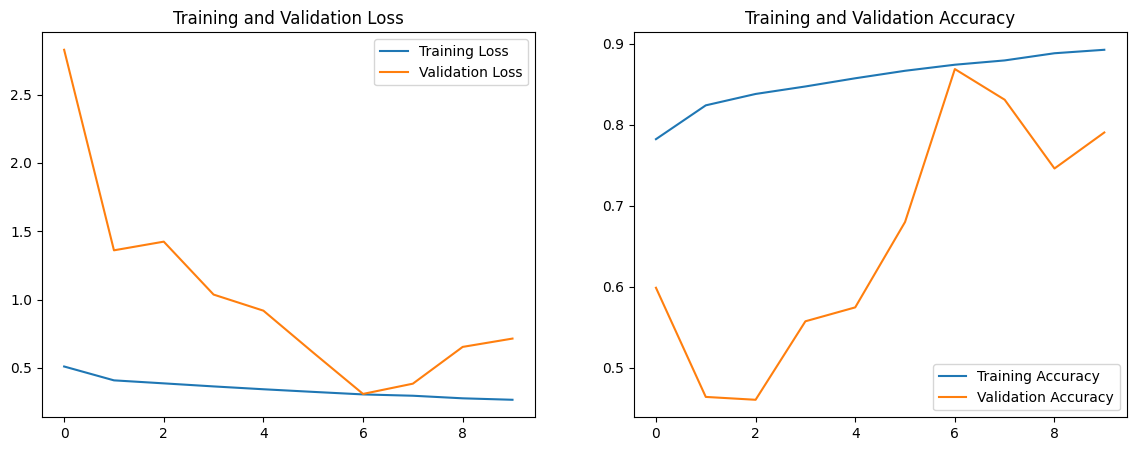

In [9]:
epochs = 10
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(epochs):
    # Training
    train_loss, train_acc = 0, 0
    iterations = np.floor(split_idx / batch_size).astype(int)
    with trange(iterations) as t:
        for i in t:
            start_idx = i * batch_size
            x_batch = X[start_idx:start_idx + batch_size]
            y_batch = y[start_idx:start_idx + batch_size]

            metrics = train_step(x_batch, y_batch)
            train_loss += metrics[0]
            train_acc += metrics[1]

            t.set_description(f'Running training epoch {epoch}')
            t.set_postfix(loss=f"{train_loss.numpy() / (i + 1):.2f}", acc=f"{train_acc.numpy() / (i + 1):.2f}")

    train_losses.append(train_loss.numpy() / iterations)
    train_accuracies.append(train_acc.numpy() / iterations)
    
    # Validation
    val_loss, val_acc = 0, 0
    val_iterations = np.floor((y.shape[0] - split_idx) / batch_size).astype(int)
    with trange(val_iterations) as t:
        for i in t:
            start_idx = split_idx + i * batch_size
            x_batch = X[start_idx:start_idx + batch_size]
            y_batch = y[start_idx:start_idx + batch_size]

            metrics = model.test_on_batch(x_batch, y_batch)
            val_loss += metrics[0]
            val_acc += metrics[1]

            t.set_description('Running validation')
            t.set_postfix(loss=f"{val_loss / (i + 1):.2f}", acc=f"{val_acc / (i + 1):.2f}")

    val_losses.append(val_loss / val_iterations)
    val_accuracies.append(val_acc / val_iterations)

print("Training complete.")
print("Validation loss:", val_losses[-1])
print("Validation accuracy:", val_accuracies[-1])

# Visualization
epochs_range = range(epochs)

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.show()


While the training data improved, the validation scores began getting worse in the third epoch, implying the model is overfitting

## Model 2

I'm going to try implement some data cleaning and add some features to the model to see if it gets better results based on my EDA.

In [15]:
PIXEL_THRESHOLD = 0.4

def filter_images(X, y, threshold=PIXEL_THRESHOLD):
    filtered_X = []
    filtered_y = []
    for i in range(len(X)):
        image = X[i]
        # Calculate the frequency of pixels with value 255
        freq_255 = np.sum(image == 255) / (image.shape[0] * image.shape[1] * image.shape[2])
        if freq_255 < threshold:
            filtered_X.append(image)
            filtered_y.append(y[i])
    return np.array(filtered_X), np.array(filtered_y)

def extract_features(X):
    brightness = []
    color_spectrum = []
    for image in X:
        # Convert the image to grayscale to calculate brightness
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        brightness.append(np.mean(gray))
        
        # Calculate color spectrum
        red = np.mean(image[:, :, 0])
        green = np.mean(image[:, :, 1])
        blue = np.mean(image[:, :, 2])
        color_spectrum.append([red, green, blue])
        
    return np.array(brightness), np.array(color_spectrum)

filtered_X, filtered_y = filter_images(X, y)

brightness, color_spectrum = extract_features(filtered_X)

filtered_X = filtered_X / 255.0

print("Original Images Shape:", X.shape)
print("Filtered Images Shape:", filtered_X.shape)
print("Brightness Shape:", brightness.shape)
print("Color Spectrum Shape:", color_spectrum.shape)

Original Images Shape: (22002, 96, 96, 3)
Filtered Images Shape: (21996, 96, 96, 3)
Brightness Shape: (21996,)
Color Spectrum Shape: (21996, 3)


I may go back and change the threshold but I think this is a good start for removing some junk images. I think I'm also going to run more epochs and stop training once validation scores stop improving

In [16]:
# Model parameters
kernel_size = (3, 3)
pool_size = (2, 2)
first_filters = 32
second_filters = 64
third_filters = 128
dropout_conv = 0.5
dropout_dense = 0.5

# Image data input
image_input = Input(shape=(96, 96, 3))

# Conv block 1
x = Conv2D(first_filters, kernel_size, use_bias=False)(image_input)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Conv2D(first_filters, kernel_size, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = MaxPool2D(pool_size=pool_size)(x)
x = Dropout(dropout_conv)(x)

# Conv block 2
x = Conv2D(second_filters, kernel_size, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Conv2D(second_filters, kernel_size, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = MaxPool2D(pool_size=pool_size)(x)
x = Dropout(dropout_conv)(x)

# Conv block 3
x = Conv2D(third_filters, kernel_size, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Conv2D(third_filters, kernel_size, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = MaxPool2D(pool_size=pool_size)(x)
x = Dropout(dropout_conv)(x)

# Flatten the CNN output
x = Flatten()(x)

# Additional features input
additional_input = Input(shape=(4,))  # 1 brightness + 3 color spectrum values
y = Dense(128, activation='relu')(additional_input)
y = Dropout(dropout_dense)(y)

# Concatenate CNN output and additional features
combined = concatenate([x, y])

# Fully connected layers after concatenation
z = Dense(256, activation='relu')(combined)
z = Dropout(dropout_dense)(z)
z = Dense(128, activation='relu')(z)
z = Dropout(dropout_dense)(z)
output = Dense(1, activation='sigmoid')(z)

# Create the model
model = Model(inputs=[image_input, additional_input], outputs=output)

# Compile the model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(0.001),
              metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)

@tf.function
def train_step(image_batch, feature_batch, y_batch):
    y_batch = tf.cast(tf.reshape(y_batch, (-1, 1)), tf.float32)
    with tf.GradientTape() as tape:
        predictions = model([image_batch, feature_batch], training=True)
        loss = tf.keras.losses.binary_crossentropy(y_batch, predictions)
        accuracy = tf.keras.metrics.binary_accuracy(y_batch, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    model.optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return tf.reduce_mean(loss), tf.reduce_mean(accuracy)

In [17]:
# Garbage collection
X = None
y = None

gc.collect()

2460

In [18]:
# Split the data into training and validation sets
split_idx = int(0.8 * len(filtered_X))
X_train_images, X_val_images = filtered_X[:split_idx], filtered_X[split_idx:]
X_train_features, X_val_features = np.concatenate([brightness[:split_idx].reshape(-1, 1), color_spectrum[:split_idx]], axis=1), np.concatenate([brightness[split_idx:].reshape(-1, 1), color_spectrum[split_idx:]], axis=1)
y_train, y_val = filtered_y[:split_idx], filtered_y[split_idx:]

# Garbage collection
filtered_X = None
filtered_y = None
brightness = None
color_spectrum = None

gc.collect()



  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

AttributeError: 'NoneType' object has no attribute 'get_weights'

Epoch 1/20
71/71 [==============================] - 23s 312ms/step - loss: 0.6281 - accuracy: 0.5954 - val_loss: 0.6936 - val_accuracy: 0.5473
Epoch 2/20
71/71 [==============================] - 20s 289ms/step - loss: 0.6271 - accuracy: 0.6005 - val_loss: 0.6942 - val_accuracy: 0.5464
Epoch 3/20
71/71 [==============================] - 20s 279ms/step - loss: 0.6278 - accuracy: 0.6075 - val_loss: 0.6946 - val_accuracy: 0.5443


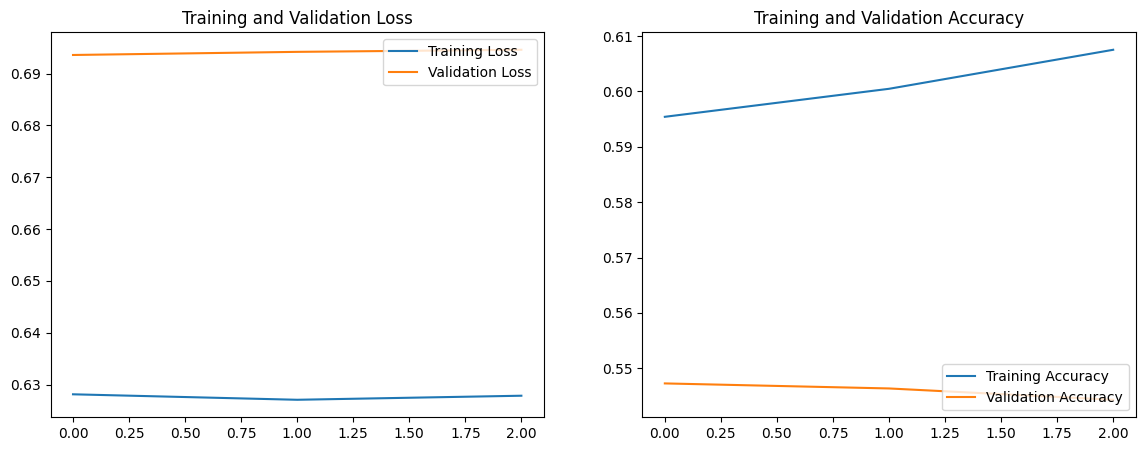

In [19]:
train_data = [X_train_images, X_train_features]
val_data = [X_val_images, X_val_features]

# Train the model using model.fit
history = model.fit(train_data, y_train,
                    epochs=20,
                    batch_size=250,
                    validation_data=(val_data, y_val),
                    callbacks=[early_stopping, reduce_lr])

# Visualize the training and validation metrics
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.show()

Trying to do data-science feature engineering is not the right call for improving this model. It seems I'm better off letting the CNN find the features and learn from those on its own rather than feeding it garbage data that it tries to correlate.

## Model 3

In [4]:
data_portion = 0.1

In [5]:
N = int(df["path"].size * data_portion)
X,y = load_data(N=N,df=df)
training_portion = 0.8
split_idx = int(np.round(training_portion * y.shape[0]))

np.random.seed(42)

#shuffle
idx = np.arange(y.shape[0])
np.random.shuffle(idx)
X = X[idx]
y = y[idx]

X_train, X_val = X[:split_idx], X[split_idx:]
y_train, y_val = y[:split_idx], y[split_idx:]

  0%|          | 0/22002 [00:00<?, ?it/s]

In [8]:
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

#dropout is used for regularization here with a probability of 0.3 for conv layers, 0.5 for the dense layer at the end
dropout_conv = 0.3
dropout_dense = 0.5

#initialize the model
model = Sequential()

#now add layers to it
model.add(Input(shape=(96, 96, 3)))

#conv block 1
model.add(Conv2D(first_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(first_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

#conv block 2
model.add(Conv2D(second_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(second_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

#conv block 3
model.add(Conv2D(third_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(third_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

#a fully connected (also called dense) layer at the end
model.add(Flatten())
model.add(Dense(256, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(dropout_dense))

#finally convert to values of 0 to 1 using the sigmoid activation function
model.add(Dense(1, activation = "sigmoid"))

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Compile the model
model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adam(0.001), 
              metrics=['accuracy'])



Epoch 1/20
71/71 [==============================] - 25s 322ms/step - loss: 0.4960 - accuracy: 0.7860 - val_loss: 4.3787 - val_accuracy: 0.5973 - lr: 0.0010
Epoch 2/20
71/71 [==============================] - 20s 281ms/step - loss: 0.4091 - accuracy: 0.8275 - val_loss: 1.2827 - val_accuracy: 0.5968 - lr: 0.0010
Epoch 3/20
71/71 [==============================] - 19s 270ms/step - loss: 0.3740 - accuracy: 0.8402 - val_loss: 1.0788 - val_accuracy: 0.6093 - lr: 0.0010
Epoch 4/20
71/71 [==============================] - 20s 283ms/step - loss: 0.3583 - accuracy: 0.8477 - val_loss: 0.7498 - val_accuracy: 0.6652 - lr: 0.0010
Epoch 5/20
71/71 [==============================] - 20s 280ms/step - loss: 0.3434 - accuracy: 0.8567 - val_loss: 0.6503 - val_accuracy: 0.6945 - lr: 0.0010
Epoch 6/20
71/71 [==============================] - 21s 301ms/step - loss: 0.3356 - accuracy: 0.8630 - val_loss: 0.5048 - val_accuracy: 0.7659 - lr: 0.0010
Epoch 7/20
71/71 [==============================] - 20s 285ms/st

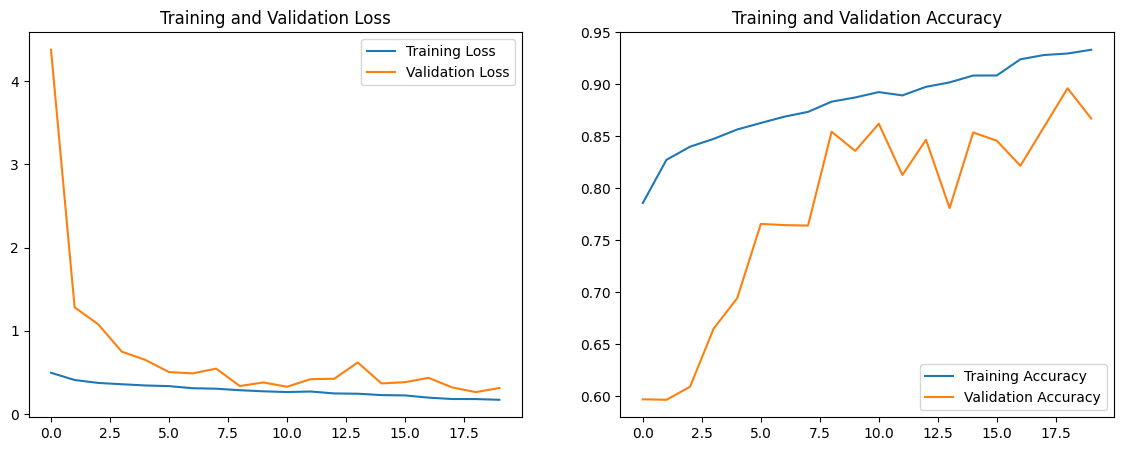

In [16]:
gc.collect()

batch_size = 250
epochs = 20

history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping, model_checkpoint, reduce_lr])

# Visualize the training history
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.show()

## Model 4

In [7]:
#data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

Epoch 1/20
70/70 [==============================] - 52s 658ms/step - loss: 0.5106 - accuracy: 0.7774 - val_loss: 6.8931 - val_accuracy: 0.5970 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 46s 661ms/step - loss: 0.4207 - accuracy: 0.8174 - val_loss: 0.8817 - val_accuracy: 0.5152 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 45s 646ms/step - loss: 0.4046 - accuracy: 0.8295 - val_loss: 1.6247 - val_accuracy: 0.4852 - lr: 0.0010
Epoch 4/20
70/70 [==============================] - 46s 656ms/step - loss: 0.3849 - accuracy: 0.8336 - val_loss: 1.5798 - val_accuracy: 0.5982 - lr: 0.0010
Epoch 5/20
70/70 [==============================] - 51s 726ms/step - loss: 0.3694 - accuracy: 0.8430 - val_loss: 0.6333 - val_accuracy: 0.7720 - lr: 0.0010
Epoch 6/20
70/70 [==============================] - 47s 666ms/step - loss: 0.3603 - accuracy: 0.8488 - val_loss: 0.5625 - val_accuracy: 0.7605 - lr: 0.0010
Epoch 7/20
70/70 [==============================] - 49s 694ms/st

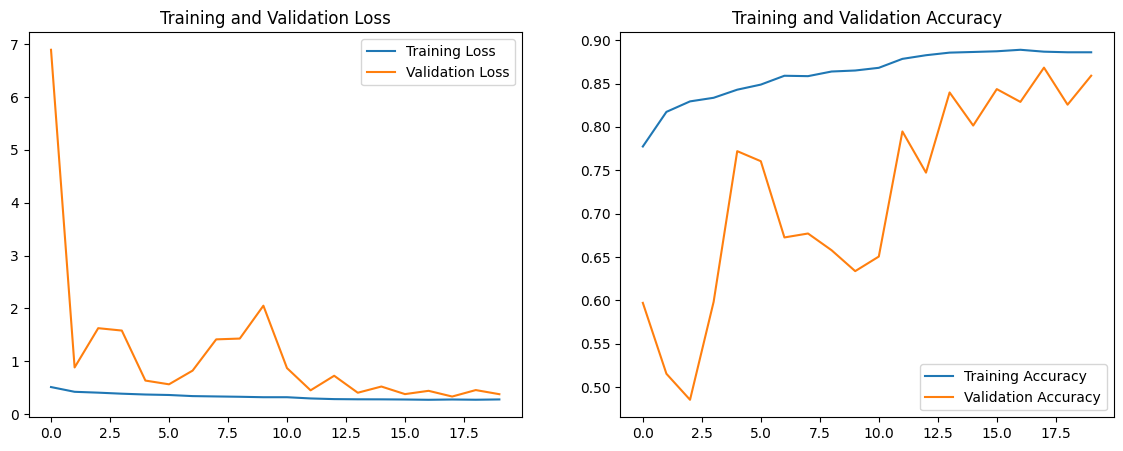

In [8]:
gc.collect()

batch_size = 250
epochs = 20

#fit the model
history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                    steps_per_epoch=len(X_train) // batch_size,
                    epochs=epochs,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping, model_checkpoint, reduce_lr])

# Visualize the training history
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.show()

## Model 5

In [9]:
gc.collect()

# Assuming load_data is a function that loads your data
N = int(df["path"].size * data_portion)
X, y = load_data(N=N, df=df)
training_portion = 0.8

np.random.seed(42)

# Shuffle
idx = np.arange(y.shape[0])
np.random.shuffle(idx)
X = X[idx]
y = y[idx]

# Split data into training and validation sets
split_idx = int(np.round(training_portion * y.shape[0]))
X_train, X_val = X[:split_idx], X[split_idx:]
y_train, y_val = y[:split_idx], y[split_idx:]


  0%|          | 0/22002 [00:00<?, ?it/s]

In [10]:

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  NVIDIA GeForce GTX 1070, compute capability 6.1
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


Epoch 1/20
71/71 [==============================] - 27s 264ms/step - loss: 0.3638 - accuracy: 0.8456 - val_loss: 0.9714 - val_accuracy: 0.6918 - lr: 0.0010
Epoch 2/20
71/71 [==============================] - 25s 259ms/step - loss: 0.3399 - accuracy: 0.8554 - val_loss: 1.0076 - val_accuracy: 0.7284 - lr: 0.0010
Epoch 3/20
71/71 [==============================] - 25s 251ms/step - loss: 0.3350 - accuracy: 0.8577 - val_loss: 0.4193 - val_accuracy: 0.8150 - lr: 0.0010
Epoch 4/20
71/71 [==============================] - 25s 252ms/step - loss: 0.3234 - accuracy: 0.8643 - val_loss: 1.1092 - val_accuracy: 0.7286 - lr: 0.0010
Epoch 5/20
71/71 [==============================] - 25s 251ms/step - loss: 0.3057 - accuracy: 0.8735 - val_loss: 0.7298 - val_accuracy: 0.7350 - lr: 0.0010
Epoch 6/20
71/71 [==============================] - 24s 250ms/step - loss: 0.3103 - accuracy: 0.8665 - val_loss: 0.4900 - val_accuracy: 0.8191 - lr: 0.0010
Epoch 7/20
71/71 [==============================] - 24s 248ms/st

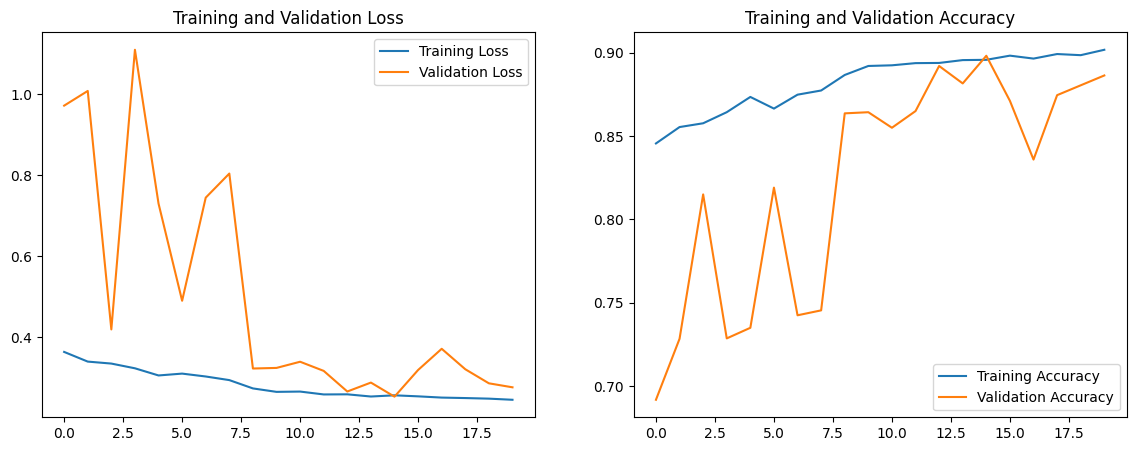

In [11]:

batch_size = 250
epochs = 20

# Create a dataset from the numpy arrays
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))

# Apply data augmentation to the training data
def augment_data(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    return image, label

train_dataset = train_dataset.map(augment_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=10000).batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Fit the model
history = model.fit(train_dataset,
                    epochs=epochs,
                    validation_data=val_dataset,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr])

# Visualize the training history
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.show()

## Model 6

In [7]:
gc.collect()

data_portion = 0.1

# Assuming load_data is a function that loads your data
N = int(df["path"].size * data_portion)
X, y = load_data(N=N, df=df)
training_portion = 0.8

np.random.seed(42)

# Shuffle
idx = np.arange(y.shape[0])
np.random.shuffle(idx)
X = X[idx]
y = y[idx]

# Split data into training and validation sets
split_idx = int(np.round(training_portion * y.shape[0]))
X_train, X_val = X[:split_idx], X[split_idx:]
y_train, y_val = y[:split_idx], y[split_idx:]


  0%|          | 0/22002 [00:00<?, ?it/s]

In [18]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

batch_size = 250
epochs = 20

# Create a dataset from the numpy arrays
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))

# Function to apply data augmentation using tf.data
def augment_data(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    return image, label

# Apply data augmentation to the training data
train_dataset = train_dataset.map(augment_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=10000).batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Calculate steps per epoch
steps_per_epoch = len(X_train) // batch_size

# Custom dynamic learning rate scheduler
class CustomLearningRateScheduler(tf.keras.callbacks.Callback):
    def __init__(self, base_lr, max_lr, scale_fn, scale_mode='cycle'):
        super().__init__()
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.scale_fn = scale_fn
        self.scale_mode = scale_mode
        self.lrs = []

    def on_train_begin(self, logs=None):
        self.iterations = 0
        self.history = {}

    def on_batch_end(self, batch, logs=None):
        self.iterations += 1
        lr = self.get_lr()
        tf.keras.backend.set_value(self.model.optimizer.lr, lr)
        self.lrs.append(lr)

    def get_lr(self):
        cycle = np.floor(1 + self.iterations / (2 * steps_per_epoch))
        x = np.abs(self.iterations / steps_per_epoch - 2 * cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr - self.base_lr) * np.maximum(0, (1 - x)) * self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr - self.base_lr) * np.maximum(0, (1 - x)) * self.scale_fn(self.iterations)

# Define the scale function for dynamic adjustments
def scale_fn(x):
    return 1 / (2.0 ** (x - 1))

Epoch 1/20
71/71 [==============================] - 38s 364ms/step - loss: 0.3064 - accuracy: 0.8737 - val_loss: 0.6760 - val_accuracy: 0.7816
Epoch 2/20
71/71 [==============================] - 39s 373ms/step - loss: 0.3147 - accuracy: 0.8676 - val_loss: 0.3924 - val_accuracy: 0.8316
Epoch 3/20
71/71 [==============================] - 38s 360ms/step - loss: 0.2922 - accuracy: 0.8780 - val_loss: 0.7113 - val_accuracy: 0.7493
Epoch 4/20
71/71 [==============================] - 38s 360ms/step - loss: 0.2893 - accuracy: 0.8821 - val_loss: 0.2899 - val_accuracy: 0.8786
Epoch 5/20
71/71 [==============================] - 45s 469ms/step - loss: 0.2828 - accuracy: 0.8846 - val_loss: 0.4054 - val_accuracy: 0.8291
Epoch 6/20
71/71 [==============================] - 42s 380ms/step - loss: 0.2763 - accuracy: 0.8872 - val_loss: 0.3275 - val_accuracy: 0.8645
Epoch 7/20
71/71 [==============================] - 42s 418ms/step - loss: 0.2705 - accuracy: 0.8905 - val_loss: 0.3721 - val_accuracy: 0.8395

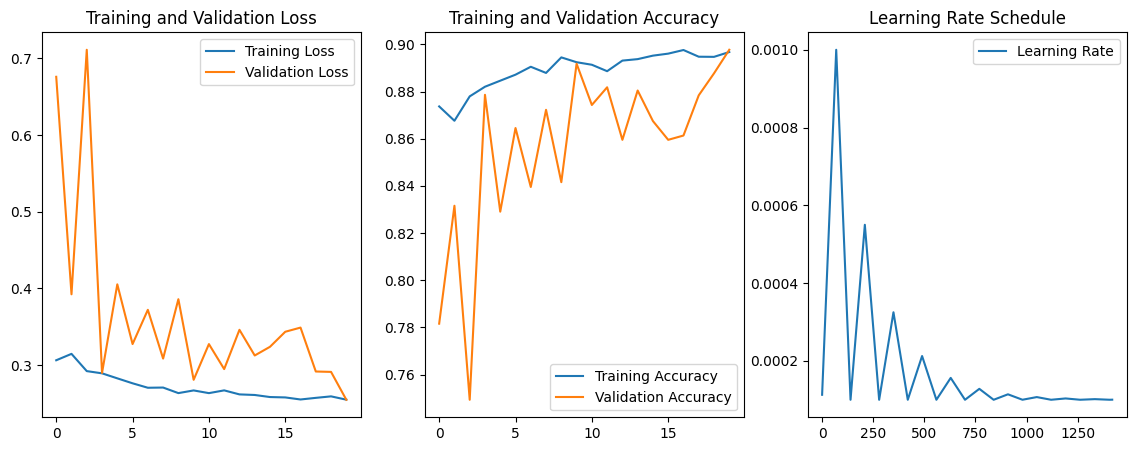

In [19]:
gc.collect()

custom_lr_scheduler = CustomLearningRateScheduler(base_lr=0.0001, max_lr=0.001, scale_fn=scale_fn)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)

# Fit the model
history = model.fit(train_dataset,
                    epochs=epochs,
                    validation_data=val_dataset,
                    callbacks=[early_stopping, model_checkpoint, custom_lr_scheduler])


# Visualize the training history
plt.figure(figsize=(14, 5))
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.subplot(1, 3, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plotting Learning Rate changes from CustomLearningRateScheduler
plt.subplot(1, 3, 3)
plt.plot(custom_lr_scheduler.lrs, label='Learning Rate')
plt.legend(loc='upper right')
plt.title('Learning Rate Schedule')

plt.show()

It looks like a custom Learning Rate has its benefits, but it appears I may get better results sticking to normal ReduceLR algorithm

# Final Model

I've cleaned up my batch automation and overall polished my model to include the best features from my learning.

In [38]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization, Activation, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from glob import glob
from tqdm.notebook import tqdm, trange

def load_data(N,df):
    """ This functions loads N images using the data df
    """
    # allocate a numpy array for the images (N, 96x96px, 3 channels, values 0 - 255)
    X = np.zeros([N,96,96,3],dtype=np.uint8) 
    #convert the labels to a numpy array too
    y = y = np.squeeze(df[['label']].values)[0:N]
    #read images one by one, tdqm notebook displays a progress bar
    for i, row in tqdm(df.iterrows(), total=N):
        if i == N:
            break
        X[i] = cv2.imread(row['path'])
          
    return X,y

base_path = os.path.dirname(os.path.abspath('notebook.ipynb'))
data_path = os.path.join(base_path, "data")
train_path = os.path.join(data_path, 'train')
test_path = os.path.join(data_path, 'test')

# Load the filenames
df = pd.DataFrame({'path': glob(os.path.join(train_path, '*.tif'))})

# Extract the file names and keep only the file names in 'id'
df['id'] = df.path.map(lambda x: os.path.splitext(os.path.basename(x))[0])

# Read the provided labels
labels = pd.read_csv(os.path.join(data_path, "train_labels.csv"))

# Merge labels and filepaths
df = df.merge(labels, on="id")

data_portion = 0.1

N = int(df["path"].size * data_portion)
X, y = load_data(N=N, df=df)
training_portion = 0.8

np.random.seed(42)

# Shuffle
idx = np.arange(y.shape[0])
np.random.shuffle(idx)
X = X[idx]
y = y[idx]

# Split data into training and validation sets
split_idx = int(np.round(training_portion * y.shape[0]))
X_train, X_val = X[:split_idx], X[split_idx:]
y_train, y_val = y[:split_idx], y[split_idx:]

# Create a dataset from the numpy arrays
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))

# Apply data augmentation to the training data
def augment_data(image, label):
    #image = tf.image.random_flip_left_right(image)
    #image = tf.image.random_flip_up_down(image)
    #image = tf.image.random_brightness(image, max_delta=0.2)
    #image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    return image, label

train_dataset = train_dataset.map(augment_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=10000).batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

  0%|          | 0/22002 [00:00<?, ?it/s]

In [39]:
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128
fourth_filters = 256

#dropout is used for regularization
dropout_conv = 0.3
dropout_dense = 0.5

#initialize the model
model = Sequential()

#now add layers to it
model.add(Input(shape=(96, 96, 3)))

#conv block 1
model.add(Conv2D(first_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(first_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

#conv block 2
model.add(Conv2D(second_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(second_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

#conv block 3
model.add(Conv2D(third_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(third_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

#conv block 4
model.add(Conv2D(fourth_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(fourth_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

#a fully connected (also called dense) layer at the end
model.add(Flatten())
model.add(Dense(128, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(dropout_dense))

#finally convert to values of 0 to 1 using the sigmoid activation function
model.add(Dense(1, activation = "sigmoid"))

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.6, patience=2, min_lr=0.00001, verbose=1)

# Compile the model
model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adam(0.001), 
              metrics=['accuracy'])



Epoch 1/20
276/276 [==============================] - 23s 74ms/step - loss: 0.4859 - accuracy: 0.7866 - val_loss: 0.8755 - val_accuracy: 0.6455 - lr: 0.0010
Epoch 2/20
276/276 [==============================] - 21s 74ms/step - loss: 0.4082 - accuracy: 0.8262 - val_loss: 0.6662 - val_accuracy: 0.7430 - lr: 0.0010
Epoch 3/20
276/276 [==============================] - 17s 63ms/step - loss: 0.3838 - accuracy: 0.8343 - val_loss: 0.4466 - val_accuracy: 0.7873 - lr: 0.0010
Epoch 4/20
276/276 [==============================] - 17s 61ms/step - loss: 0.3653 - accuracy: 0.8417 - val_loss: 0.6341 - val_accuracy: 0.7239 - lr: 0.0010
Epoch 5/20
276/276 [==============================] - 20s 72ms/step - loss: 0.3605 - accuracy: 0.8467 - val_loss: 0.3974 - val_accuracy: 0.8211 - lr: 0.0010
Epoch 6/20
276/276 [==============================] - 17s 61ms/step - loss: 0.3383 - accuracy: 0.8565 - val_loss: 0.5063 - val_accuracy: 0.8052 - lr: 0.0010
Epoch 7/20
276/276 [==============================] - 17s 

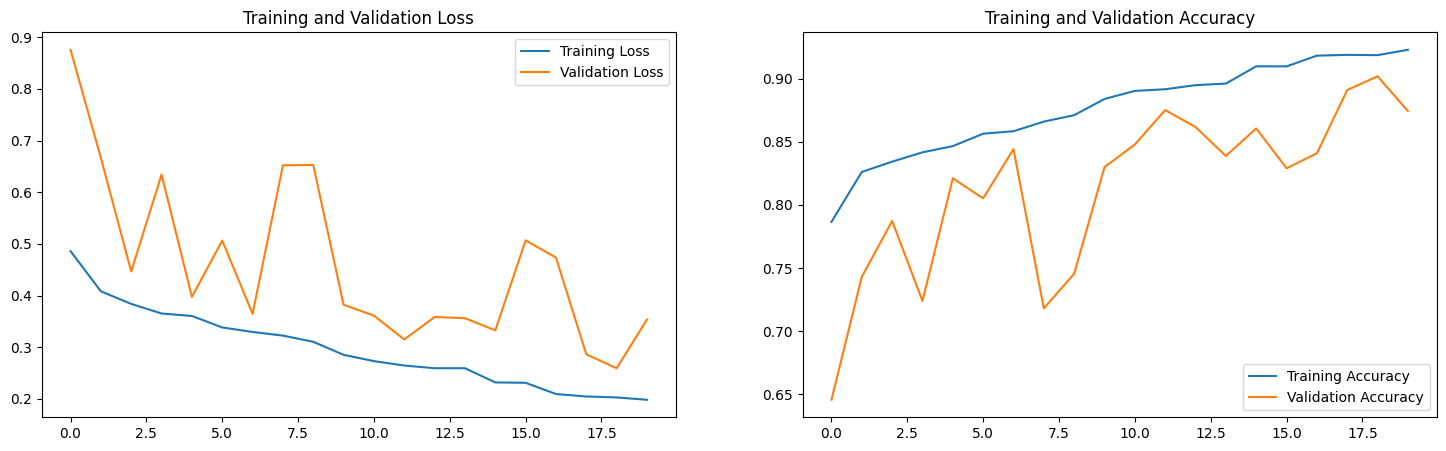

In [40]:
# Fit the model
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

# Visualize the training history
plt.figure(figsize=(18, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.show()

In [41]:
model.save('best_model.h5')

# Running Test Data

In [42]:
# Load the test filenames
test_df = pd.DataFrame({'path': glob(os.path.join(test_path, '*.tif'))})
test_df['id'] = test_df.path.map(lambda x: os.path.splitext(os.path.basename(x))[0])

# Load test data
def load_test_data(df):
    N = len(df)
    X_test = np.zeros([N, 96, 96, 3], dtype=np.uint8)
    for i, row in tqdm(df.iterrows(), total=N):
        X_test[i] = cv2.imread(row['path'])
    return X_test

X_test = load_test_data(test_df)

# Make predictions
predictions = model.predict(X_test)

# Create a DataFrame for submission
submission = pd.DataFrame({'id': test_df['id'], 'label': predictions.flatten()})

# Save the submission file
submission.to_csv('submission.csv', index=False)

print("Submission file created successfully.")

  0%|          | 0/57458 [00:00<?, ?it/s]

1796/1796 [==============================] - 19s 10ms/step
Submission file created successfully.


1/1 [==============================] - 0s 419ms/step


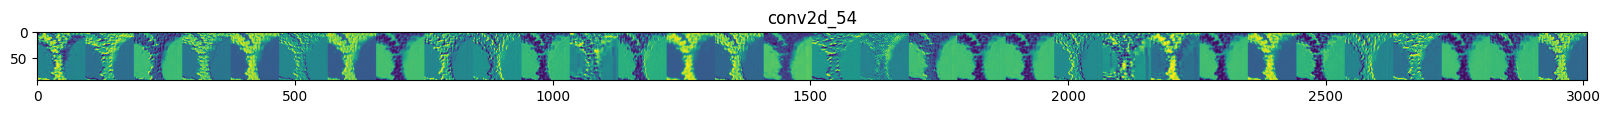

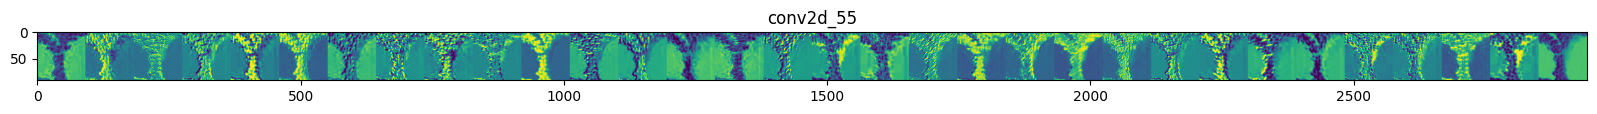

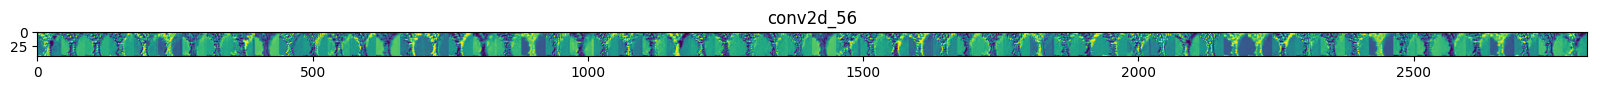

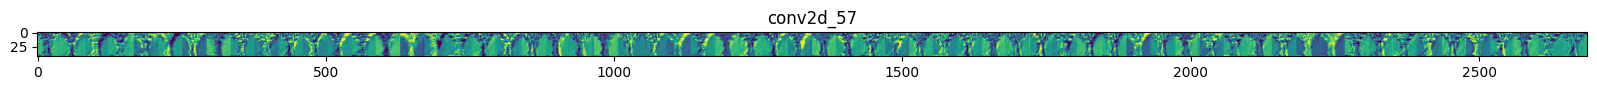

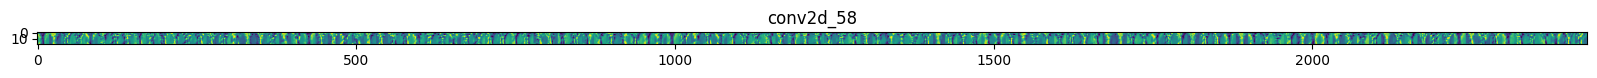

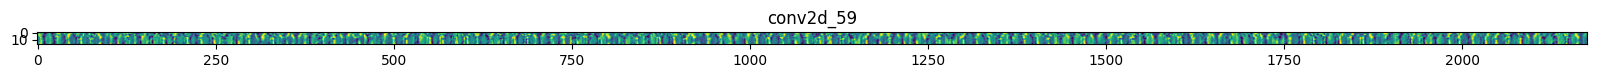

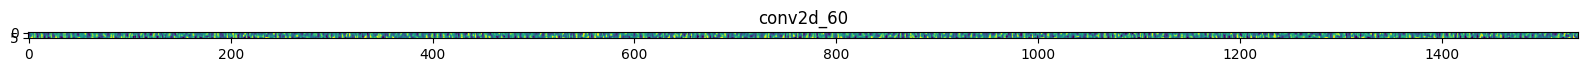

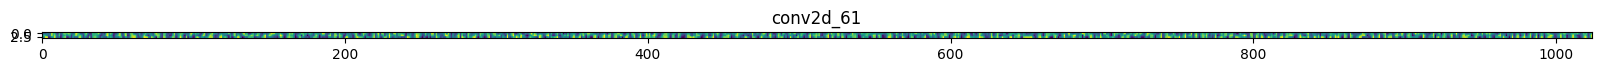

In [43]:
image_index = 0
image = X_val[image_index]
image = np.expand_dims(image, axis=0)

# Create a model that outputs the feature maps
layer_outputs = [layer.output for layer in model.layers if 'conv' in layer.name]
activation_model = Model(inputs=model.input, outputs=layer_outputs)

# Get the feature maps
activations = activation_model.predict(image)

# Plot the feature maps
layer_names = [layer.name for layer in model.layers if 'conv' in layer.name]

for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    display_grid = np.zeros((size, size * n_features))
    
    for i in range(n_features):
        x = layer_activation[0, :, :, i]
        x -= x.mean()
        x /= x.std()
        x *= 64
        x += 128
        x = np.clip(x, 0, 255).astype('uint8')
        display_grid[:, i * size : (i + 1) * size] = x
    
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

1/1 [==============================] - 0s 138ms/step


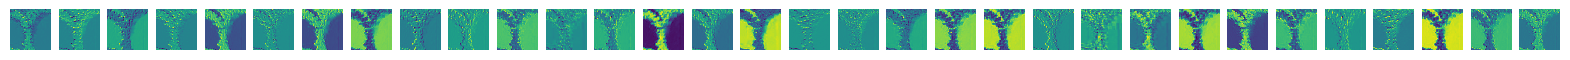

In [46]:
# Select an image from the validation set
image_index = 0
image = X_val[image_index]
image_exp = np.expand_dims(image, axis=0)

# Create a model that outputs the intermediate layers
layer_outputs = [layer.output for layer in model.layers[:8]]  # Adjust the number to select specific layers
activation_model = Model(inputs=model.input, outputs=layer_outputs)

# Get the intermediate layer outputs
activations = activation_model.predict(image_exp)

# Visualize the outputs of the first convolutional layer
first_layer_activation = activations[0]
n_features = first_layer_activation.shape[-1]

fig, axes = plt.subplots(1, n_features, figsize=(20, 20))
for i in range(n_features):
    ax = axes[i]
    ax.matshow(first_layer_activation[0, :, :, i], cmap='viridis')
    ax.axis('off')

plt.show()